<a href="https://colab.research.google.com/github/yustinachang/1121_20009_Digital-Image-Processing-and-Analysis/blob/main/Practice/231124_LiverCT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CT影像 肝臟腫瘤分割**

## 資料集中附有 images, labels 兩個影像資料夾(.npy檔)，images 中影像名稱對應到 labels 中同名的檔案 (如 images/001.npy 對應到 labels/001.npy 的 mask)。

## images 資料夾中為 CT 之原始影像 (大小為512x512)，單位為 HU (Hounsfield Unit)，介於 -3024 至 3024 之間。

## labels 資料夾中之數字矩陣 (大小為512x512) 上有 0,1,2 三種數值，分別代表**背景** (background) 、**肝臟組織** (liver, 下右圖藍色) 以及**肝臟腫瘤** (liver tumor, 下右圖粉紅色) 三種類別。

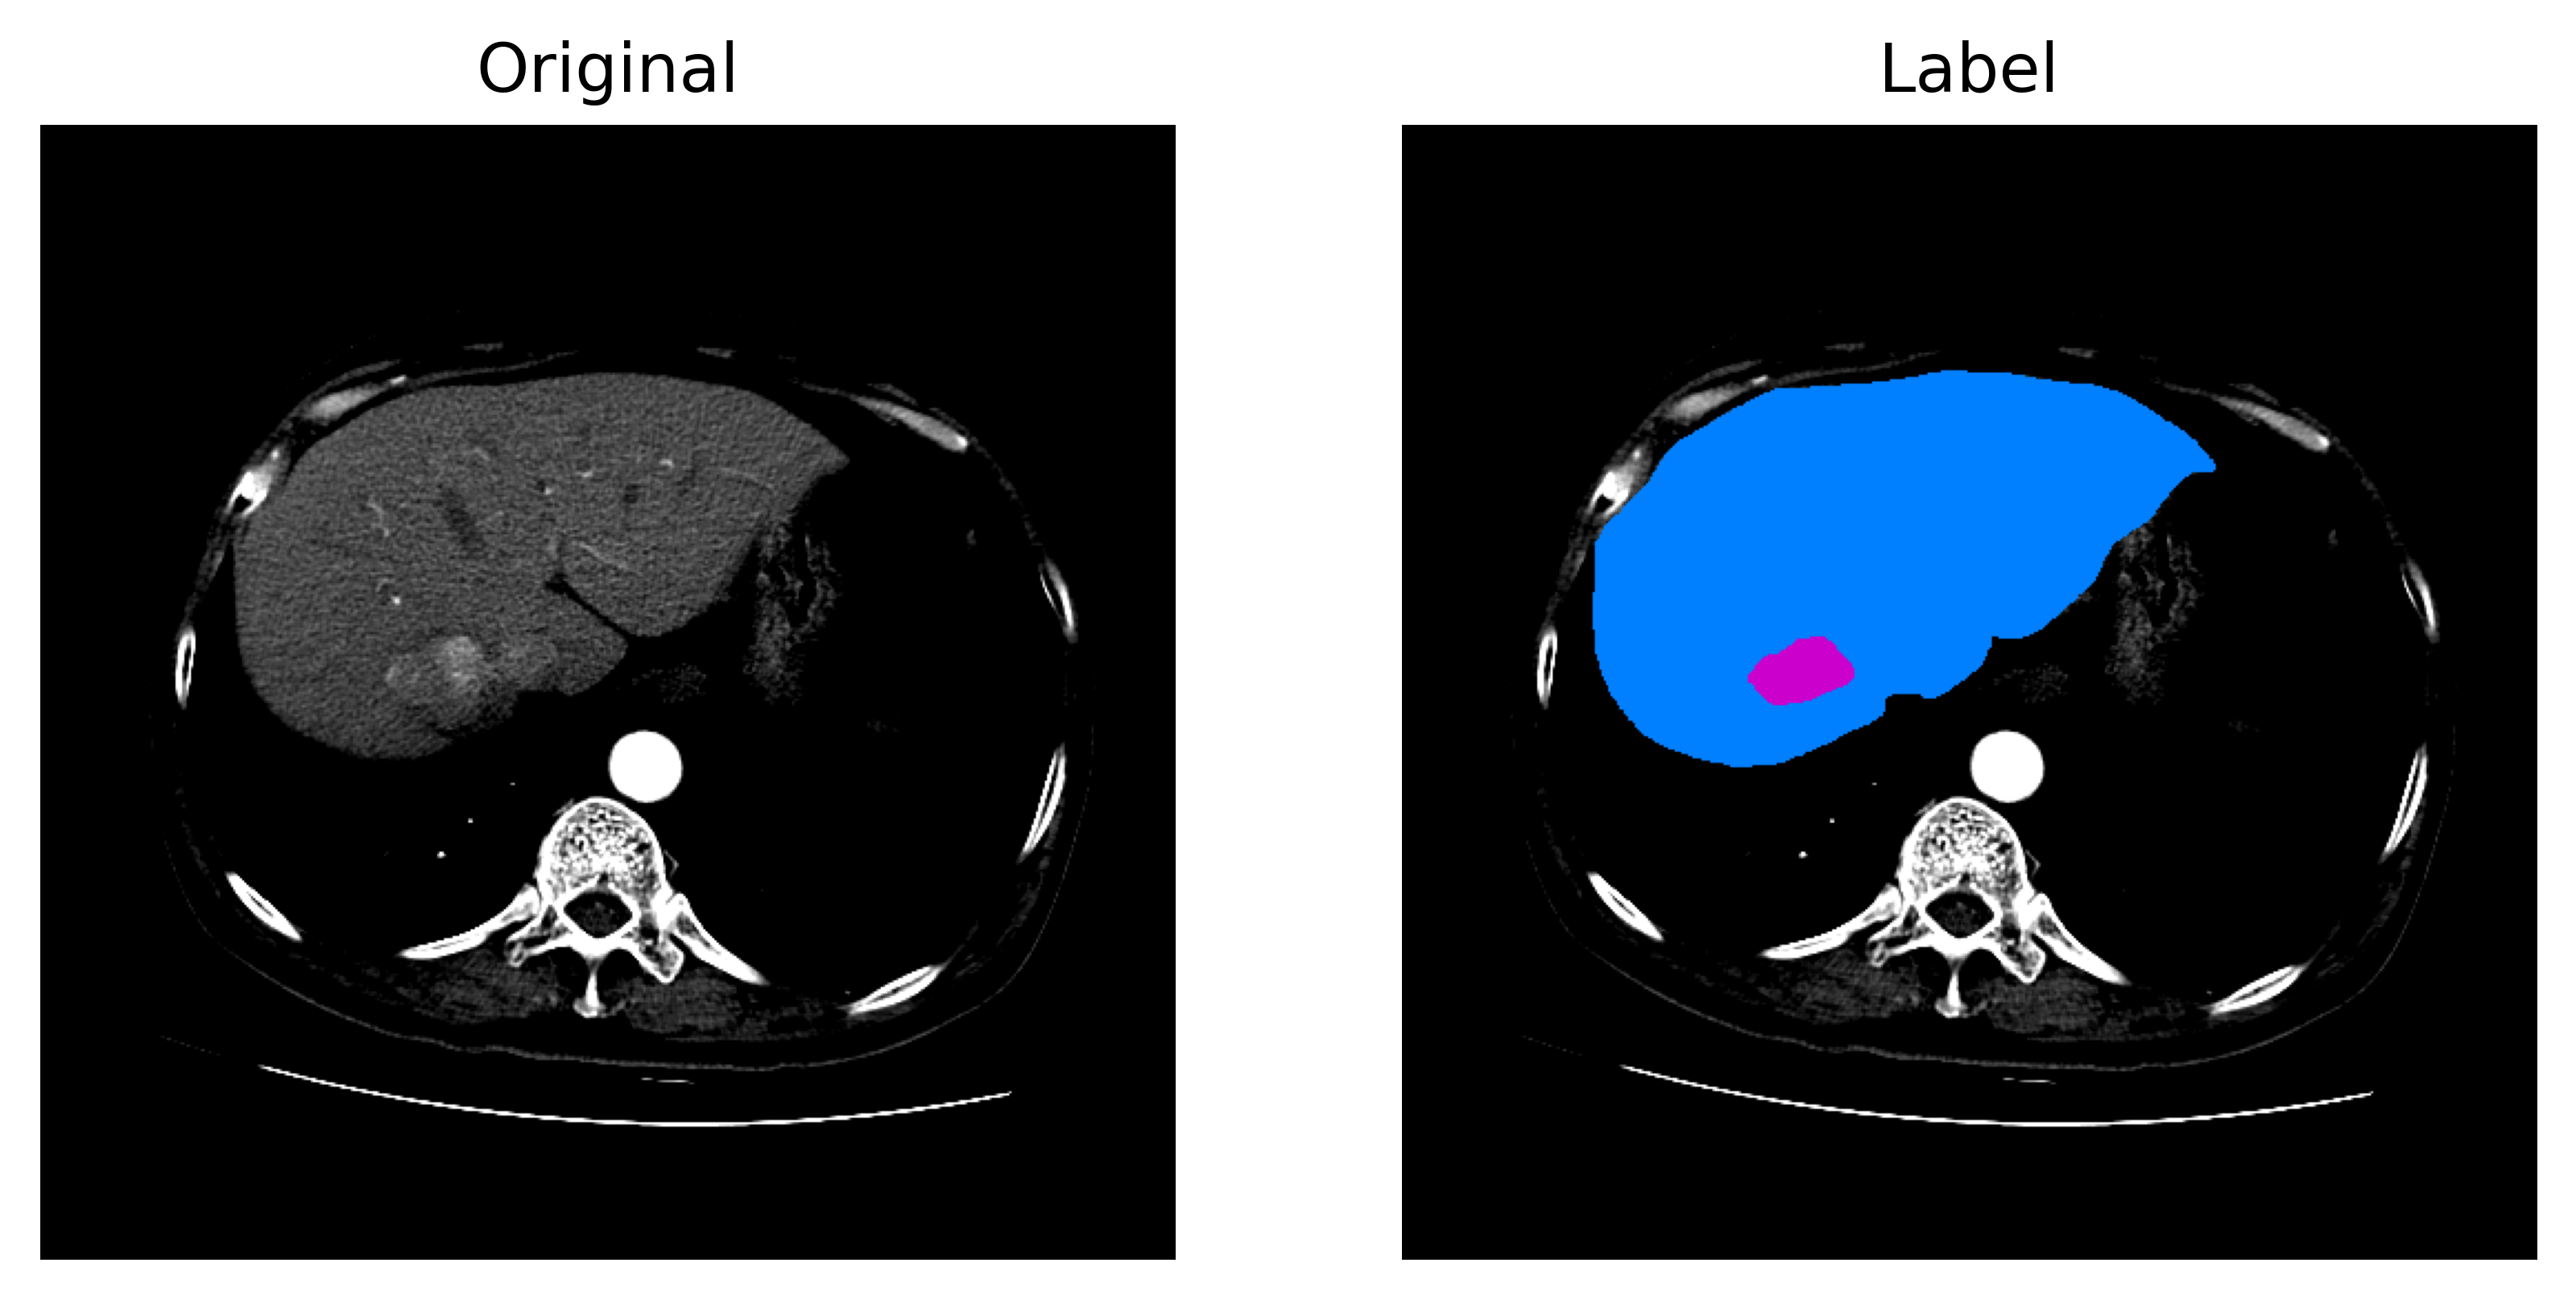

## **題目1、**
### 請嘗試建立一個分割 **肝臟組織** 與 **肝臟腫瘤** 區域之模型，另以文字說明使用的 **模型結構** 與 **參數** 選擇。
###有做 **影像前處理** 也請一併寫入。
<br></br>
## **題目2、**
### 請用訓練後之模型預測驗證集資料，並以數值說明模型針對 **肝臟組織** 及 **肝臟腫瘤** 分割之各別效能。
### 指標不限，請簡述選擇原因。
<br></br>
## 備註：
1. 若影像過大無法正常訓練模型，可自行縮小影像。
2. 訓練集及驗證集請自行分割，比例為訓練集：驗證集 = 80：20。

# **程式碼**

In [ ]:
!pip install -q opencv-python natsort # 安裝所需套件 (OpenCV影像處理套件及檔案排序套件)
!nvidia-smi # 確認有分配到GPU資源

Fri Nov 24 07:38:59 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import tensorflow.keras as keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Concatenate, BatchNormalization, Activation, Add, Conv2D, Conv2DTranspose, MaxPooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, History
import cv2
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from natsort import natsorted

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_paths = '/content/drive/MyDrive/Colab Notebooks/CMUH-AIC Medical_Image_Test' #請填入雲端中資料集所在位置
if os.path.exists(dataset_paths) :
  print(glob.glob(dataset_paths+'/*'))
else :
  print('位置錯誤或位置不存在')

['/content/drive/MyDrive/Colab Notebooks/CMUH-AIC Medical_Image_Test/images', '/content/drive/MyDrive/Colab Notebooks/CMUH-AIC Medical_Image_Test/labels', '/content/drive/MyDrive/Colab Notebooks/CMUH-AIC Medical_Image_Test/LiverCT.ipynb']


In [ ]:
def ConvBN(model, filters):
  model = Conv2D(filters, kernel_size=(3,3), padding='same', kernel_initializer='he_normal')(model)
  model = BatchNormalization()(model)
  model = Activation('relu')(model)
  return model

def Unet2D_simple(input_size, init_filters=16, n_classes=2):

  # Encoder 第一層
  inputs = Input(shape=input_size) # 256x256x1
  enc1 = ConvBN(inputs, filters=init_filters) # 256x256x16
  enc1 = ConvBN(enc1, filters=init_filters) # 256x256x16

  # Encoder 第二層
  enc2 = MaxPooling2D(pool_size=(2,2))(enc1) # 128x128x16
  enc2 = ConvBN(enc2, filters=init_filters*2) # 128x128x32
  enc2 = ConvBN(enc2, filters=init_filters*2) # 128x128x32

  # Encoder 第三層
  enc3 = MaxPooling2D(pool_size=(2,2))(enc2) # 64x64x32
  enc3 = ConvBN(enc3, filters=init_filters*4) # 64x64x64
  enc3 = ConvBN(enc3, filters=init_filters*4) # 64x64x64

  # Encoder 第四層
  enc4 = MaxPooling2D(pool_size=(2,2))(enc3) # 32x32x64
  enc4 = ConvBN(enc4, filters=init_filters*8) # 32x32x128
  enc4 = ConvBN(enc4, filters=init_filters*8) # 32x32x128

  # 最底層
  enc5 = MaxPooling2D(pool_size=(2,2))(enc4) # 16x16x128
  enc5 = ConvBN(enc5, filters=init_filters*16) # 16x16x256
  enc5 = ConvBN(enc5, filters=init_filters*16) # 16x16x256

  # Decoder 第一層 (對應Encoder4)
  dec4 = Conv2DTranspose(init_filters*8, kernel_size=(3,3), padding='same', strides=2, kernel_initializer='he_normal')(enc5) # 32x32x128
  dec4 = Concatenate(axis=-1)([dec4, enc4]) # 32x32x256
  dec4 = ConvBN(dec4, filters=init_filters*8) # 32x32x128
  dec4 = ConvBN(dec4, filters=init_filters*8) # 32x32x128

  # Decoder 第二層 (對應Encoder3)
  dec3 = Conv2DTranspose(init_filters*4, kernel_size=(3,3), padding='same', strides=2, kernel_initializer='he_normal')(dec4) # 64x64x64
  dec3 = Concatenate(axis=-1)([dec3, enc3]) # 64x64x128
  dec3 = ConvBN(dec3, filters=init_filters*4) # 64x64x64
  dec3 = ConvBN(dec3, filters=init_filters*4) # 64x64x64

  # Decoder 第三層 (對應Encoder2)
  dec2 = Conv2DTranspose(init_filters*2, kernel_size=(3,3), padding='same', strides=2, kernel_initializer='he_normal')(dec3) # 128x128x32
  dec2 = Concatenate(axis=-1)([dec2, enc2]) # 128x128x64
  dec2 = ConvBN(dec2, filters=init_filters*2) # 128x128x32
  dec2 = ConvBN(dec2, filters=init_filters*2) # 128x128x32

  # Decoder 第四層 (對應Encoder1)
  dec1 = Conv2DTranspose(init_filters, kernel_size=(3,3), padding='same', strides=2, kernel_initializer='he_normal')(dec2) # 256x256x16
  dec1 = Concatenate(axis=-1)([dec1, enc1]) # 256x256x32
  dec1 = ConvBN(dec1, filters=init_filters) # 256x256x16
  dec1 = ConvBN(dec1, filters=init_filters) # 256x256x16

  # 輸入端(Output要分為幾個class)
  out = Conv2D(n_classes, kernel_size=(1,1), padding='same')(dec1) # 256x256x2
  out = Activation('softmax')(out) # 256x256x2

  model = Model(inputs, out)
  return model

In [ ]:
model = Unet2D_simple(input_size=[256,256,1], init_filters=16, n_classes=2)

In [ ]:
class Liver(keras.utils.Sequence):
  def __init__(self, batch_size, img_size, img_paths, lbl_paths):
    self.batch_size = batch_size
    self.img_size = img_size
    self.img_paths = img_paths
    self.lbl_paths = lbl_paths

  def __len__(self):
    return len(self.lbl_paths) // self.batch_size

  def __getitem__(self, idx):
    i = idx * self.batch_size
    batch_img_paths = self.img_paths[i:i+self.batch_size]
    batch_lbl_paths = self.lbl_paths[i:i+self.batch_size]
    x = []
    for path in batch_img_paths:
      img = np.load(path)
      img[img < 25] = 25
      img[img > 175] = 175
      if img.size != self.img_size:
        img = cv2.resize(img, self.img_size, interpolation=cv2.INTER_AREA)
      img = ((img-img.min())/(img.max()-img.min()+1e-3)).astype(np.float32)
      img = np.expand_dims(img, axis=-1)
      x.append(img)
    x = np.stack(x, axis=0)
    y = []
    for path in batch_lbl_paths:
      mask = np.load(path).astype(np.uint8)
      #mask[mask > 0] = 1
      if mask.size != self.img_size:
        mask = cv2.resize(mask, self.img_size, interpolation=cv2.INTER_AREA)
      mask = np.expand_dims(mask, axis=-1)
      mask_bg = np.ones(mask.shape) - mask
      mask = np.concatenate([mask, mask_bg], axis=-1)
      y.append(mask)
    y = np.stack(y, axis=0)
    return x, y

In [ ]:
images = natsorted(glob.glob(f'{dataset_paths}/images/*.npy'))
labels = natsorted(glob.glob(f'{dataset_paths}/labels/*.npy'))
lengths = len(images)
train_images = images[:int(lengths*0.8)]
train_labels = labels[:int(lengths*0.8)]
test_images = images[int(lengths*0.8):]
test_labels = labels[int(lengths*0.8):]

In [ ]:
print(len(train_images), len(train_labels))
print(f'Image: {train_images[0]}, label: {train_labels[0]}')
print(f'Image: {test_images[42]}, label: {test_labels[42]}')

1160 1160
Image: /content/drive/MyDrive/Colab Notebooks/CMUH-AIC Medical_Image_Test/images/000_045.npy, label: /content/drive/MyDrive/Colab Notebooks/CMUH-AIC Medical_Image_Test/labels/000_045.npy
Image: /content/drive/MyDrive/Colab Notebooks/CMUH-AIC Medical_Image_Test/images/041_058.npy, label: /content/drive/MyDrive/Colab Notebooks/CMUH-AIC Medical_Image_Test/labels/041_058.npy


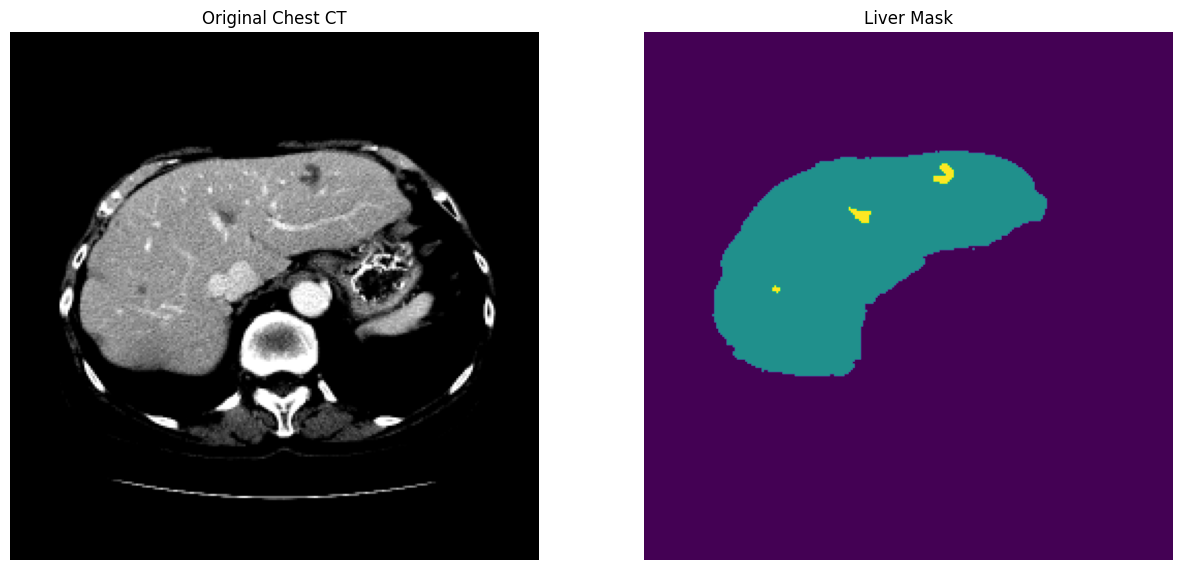

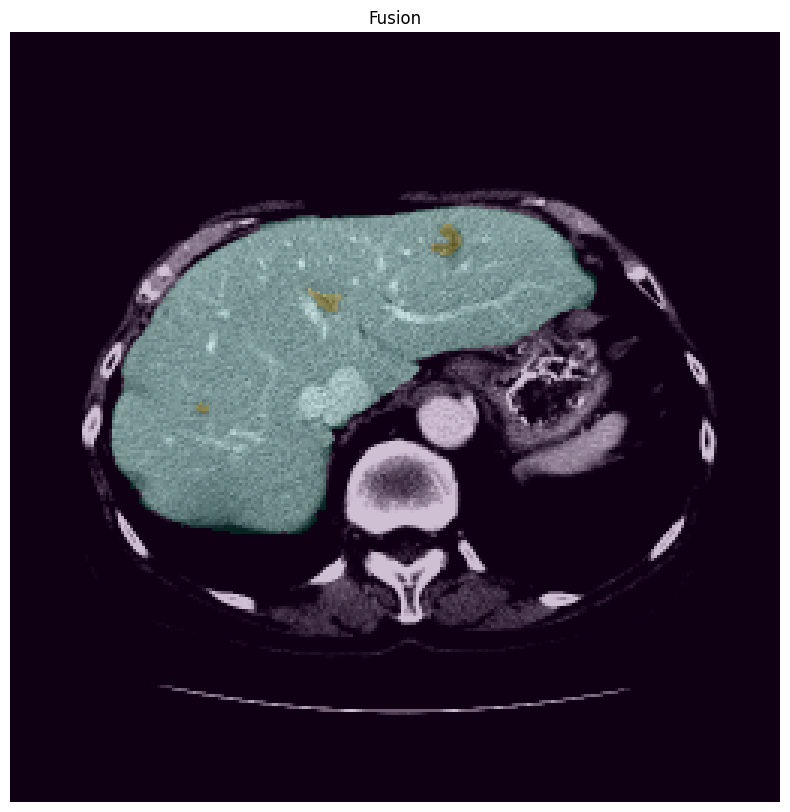

In [ ]:
train = Liver(1, (256, 256), train_images, train_labels)
image_temp, label_temp = train[50]
plt.figure(figsize=(15,15));
plt.subplot(121); plt.imshow(image_temp[0,...,0], cmap='gray'); plt.axis('off'); plt.title('Original Chest CT');
plt.subplot(122); plt.imshow(label_temp[0,...,0]); plt.axis('off'); plt.title('Liver Mask');
plt.figure(figsize=(10,10)); plt.imshow(image_temp[0,...,0], cmap='gray'); plt.imshow(label_temp[0,...,0], alpha=0.25); plt.axis('off'); plt.title('Fusion');

In [ ]:
train_gen = Liver(16, (256, 256), train_images, train_labels)
valid_gen = Liver(4, (256, 256), test_images, test_labels)

In [ ]:
def dice_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(y_true * y_pred, axis=[1,2,3])
  union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
  dice = K.mean((2. * intersection + smooth)/(union + smooth))
  return dice

def dice_loss(y_true, y_pred, smooth=1):
  intersection = K.sum(y_true * y_pred, axis=[1,2,3])
  union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
  dice = K.mean((2. * intersection + smooth)/(union + smooth))
  return K.categorical_crossentropy(y_true, y_pred) - K.log(dice)

In [ ]:
# 設定優化器(optimizer)、損失函數(loss)、效能衡量指標(metrics)的類別
model.compile(optimizer=Adam(learning_rate=1e-3), loss=dice_loss, metrics=[dice_coef])

os.makedirs('/content/drive/MyDrive/Colab Notebooks/model', exist_ok=True)
# 設定檢查點 callbacks，模型存檔
modelcheckpoint = ModelCheckpoint("/content/drive/MyDrive/Colab Notebooks/model/UNet_model.h5", monitor='val_dice_coef', mode='max', save_best_only=True)
history = History()

In [ ]:
# 訓練 10 週期(epoch)
epochs = 10
model.fit(x=train_gen, epochs=epochs, validation_data=valid_gen, callbacks=[modelcheckpoint, history]);

Epoch 1/10
72/72 [==============================] - ETA: 0s - loss: 0.1389 - dice_coef: 0.9371

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


72/72 [==============================] - 346s 5s/step - loss: 0.1389 - dice_coef: 0.9371 - val_loss: 1.2696 - val_dice_coef: 0.8740
Epoch 2/10
72/72 [==============================] - 35s 483ms/step - loss: 0.0398 - dice_coef: 0.9808 - val_loss: 0.0710 - val_dice_coef: 0.9708
Epoch 3/10
72/72 [==============================] - 32s 449ms/step - loss: 0.0050 - dice_coef: 0.9881 - val_loss: 0.7141 - val_dice_coef: 0.8804
Epoch 4/10
72/72 [==============================] - 35s 488ms/step - loss: -0.0449 - dice_coef: 0.9917 - val_loss: 0.6351 - val_dice_coef: 0.8722
Epoch 5/10
72/72 [==============================] - 33s 466ms/step - loss: -0.0925 - dice_coef: 0.9946 - val_loss: 0.3225 - val_dice_coef: 0.8992
Epoch 6/10
72/72 [==============================] - 39s 535ms/step - loss: -0.1416 - dice_coef: 0.9963 - val_loss: 0.0393 - val_dice_coef: 0.9523
Epoch 7/10
72/72 [==============================] - 37s 519ms/step - loss: -0.1943 - dice_coef: 0.9973 - val_loss: -0.1881 - val_dice_coef: 

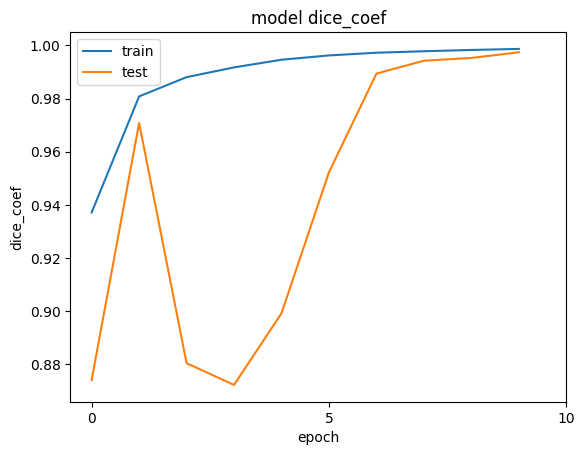

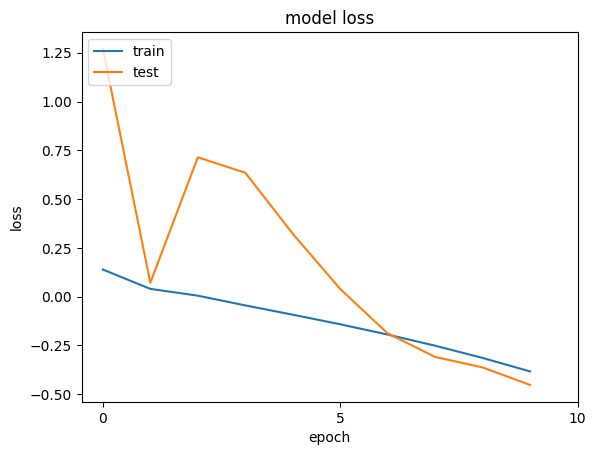

In [ ]:
plt.figure();
plt.plot(history.history['dice_coef']);
plt.plot(history.history['val_dice_coef']);
plt.title('model dice_coef'), plt.ylabel('dice_coef'), plt.xlabel('epoch'); plt.xticks(range(0,epochs+1,5));
plt.legend(['train', 'test'], loc='upper left');

plt.figure();
plt.plot(history.history['loss']);
plt.plot(history.history['val_loss']);
plt.title('model loss'), plt.ylabel('loss'), plt.xlabel('epoch'); plt.xticks(range(0,epochs+1,5));
plt.legend(['train', 'test'], loc='upper left');